Autoencoders can be used for image denoising by training the network to learn a compressed representation of the input image and then reconstruct the image from this representation.

During training, the autoencoder is fed with pairs of noisy images and clean images. The objective is to minimize the difference between the noisy input image and the clean target image. The autoencoder consists of two main parts: an encoder and a decoder. The encoder compresses the input image into a lower-dimensional representation, while the decoder reconstructs the image from this representation.

Here we will use **MSE** as the loss function for the model. We will use try two models. One sequential model and another U-net architecture with skip connections.

In [1]:
#!unzip image_denoising_dataset-200512-163438.zip

In [12]:
# import libraries and modules

%matplotlib inline

import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout

from skimage.io import imread

In [2]:
train_dir= os.path.join(os.path.abspath('.'),'train')
test_dir= os.path.join(os.path.abspath('.'),'test')

clean_dir= os.path.join(train_dir,'clean')
noisy_dir= os.path.join(train_dir,'noisy')

In [3]:
len(os.listdir(clean_dir)), len(os.listdir(noisy_dir))

(1999, 1999)

We have **1999 clean images** and corresponding **1999 noisy images** in our training data. 

In the context of denoising autoencoders, like the one we are training, the encoder learns to extract features that are robust to noise. These features are then used by the decoder to reconstruct the denoised version of the input image.

During training, the autoencoder learns to encode the input data into a lower-dimensional representation (the latent space) and decode it back to the original input as accurately as possible. 

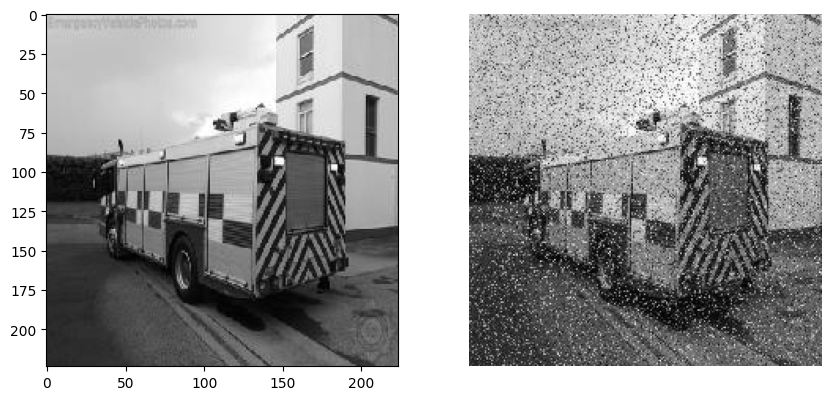

In [4]:
#let us plot a random image
rng= np.random.RandomState(100)

clean_img_name = rng.choice(os.listdir(clean_dir))


clean_filepath = os.path.join(clean_dir, clean_img_name)
noisy_filepath = os.path.join(noisy_dir, clean_img_name)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

## read images
img_clean = imread(clean_filepath, as_gray=True)
img_noisy= imread(noisy_filepath, as_gray= True)

## show image
ax[0].imshow(img_clean, cmap='gray')
plt.axis('off')

ax[1].imshow(img_noisy, cmap='gray')
plt.axis('off')

plt.show()

As can be seen, we have the clean and noisy version of the same image.

### Pre-processing

As pre-processing, we will read the images and store them as numpy arrays. We have 1999 images each of size 224x224. The last argument of 1 refers to the channel.

In [5]:
# read images and store them as numpy arrays-

## read train images
temp = []
for img_name in os.listdir(clean_dir):
    image_path = os.path.join(clean_dir, img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)
    
## store them in clean_train
clean_train = np.reshape(temp, (1999,224,224,1))
#we flatten them since we are working with Autoencoders
#clean_train = clean_train.reshape(-1, 224*224).astype('float32')

temp= []
for img_name in os.listdir(noisy_dir):
    image_path = os.path.join(noisy_dir, img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)
    
## store them in noisy_train
noisy_train = np.reshape(temp, (1999,224,224,1))
#we flatten them since we are working with Autoencoders
#noisy_train = noisy_train.reshape(-1, 224*224).astype('float32')


In [6]:
clean_train.shape, noisy_train.shape

((1999, 224, 224, 1), (1999, 224, 224, 1))

In [7]:
# print minimum and maximum values of train_x array
clean_train.min(), clean_train.max()

(0.0, 1.0)

### Model Building

We will define the encoder and decoder in a sequential fashion. In the encoder, we use convolutional layers of 64,128 and 256 filters each, all with same padding that ensures spatial dimensions of the output feature map remains same as input. We have also introduced the maxpool layers.

I have maintained a symmetry between the encoder and decoder with the only difference being that the decoder uses conv2DTranspose instead of the regular convolutional layers. The conv2DTranspose upsamples the feature map to the original spatial dimensions. 

In [29]:
# define architecture of autoencoder

## this is our input placeholder
input_img = Input(shape=(224,224,1 ))

## "encoded" is the encoded representation of the input
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) #64 filters, 3x3 kernel
encoded = MaxPooling2D((2, 2), padding='same')(encoded) #2x2 pool size
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded) 
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded) 

## "decoded" is the lossy reconstruction of the input
decoded = Conv2DTranspose(256, (3, 3), strides=(2,2),activation='relu', padding='same')(encoded)
#decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(128, (2, 2), activation='relu',strides=(2,2), padding='same')(decoded) 
#decoded = UpSampling2D((4, 4))(decoded)
decoded = Conv2DTranspose(64, (2, 2), activation='relu', strides=(2,2), padding='same')(decoded) 

decoded= Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


In [30]:
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 56, 56, 256)       295

In [9]:
from keras.optimizers.legacy import Adam

adam= Adam(learning_rate=1e-3)
# compile autoencoder
autoencoder.compile(optimizer= adam, loss='mse')

#we use mean square error because we are comparing the output from the model to the original input, pixel by pixel

In [32]:
# train autoencoder
train_history = autoencoder.fit(noisy_train, clean_train, epochs=15, batch_size=64,validation_data=(noisy_train, clean_train))

Epoch 1/15
32/32 [==============================] - 151s 5s/step - loss: 0.0512 - val_loss: 0.0223
Epoch 2/15
32/32 [==============================] - 155s 5s/step - loss: 0.0212 - val_loss: 0.0183
Epoch 3/15
32/32 [==============================] - 153s 5s/step - loss: 0.0168 - val_loss: 0.0151
Epoch 4/15
32/32 [==============================] - 152s 5s/step - loss: 0.0145 - val_loss: 0.0135
Epoch 5/15
32/32 [==============================] - 150s 5s/step - loss: 0.0133 - val_loss: 0.0128
Epoch 6/15
32/32 [==============================] - 158s 5s/step - loss: 0.0124 - val_loss: 0.0120
Epoch 7/15
32/32 [==============================] - 152s 5s/step - loss: 0.0119 - val_loss: 0.0115
Epoch 8/15
32/32 [==============================] - 150s 5s/step - loss: 0.0116 - val_loss: 0.0111
Epoch 9/15
32/32 [==============================] - 151s 5s/step - loss: 0.0111 - val_loss: 0.0113
Epoch 10/15
32/32 [==============================] - 150s 5s/step - loss: 0.0108 - val_loss: 0.0105
Epoch 11/

In [33]:
# Evaluate the model
loss = autoencoder.evaluate(noisy_train, clean_train)
print("Test Loss:", loss)

63/63 [==============================] - 41s 644ms/step - loss: 0.0094
Test Loss: 0.009445497766137123


In [34]:
## read test images
temp = []
for img_name in os.listdir(test_dir):
    image_path = os.path.join(test_dir, img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)
    
## store them in train_x
noisy_test = np.reshape(temp, (-1,224,224,1))
#noisy_test = noisy_test.reshape(-1, 224*224).astype('float32')

In [35]:
noisy_test.shape

(353, 224, 224, 1)

In [36]:
# Apply the trained autoencoder model on the test images to denoise them
denoised_test_images = autoencoder.predict(noisy_test)

12/12 [==============================] - 7s 606ms/step


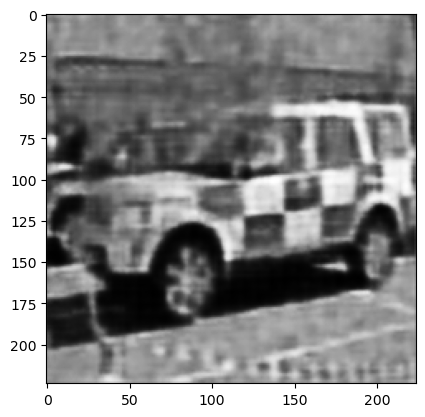

In [37]:
#check output of autoencoder model
plt.imshow(denoised_test_images[0].reshape((224,224)), cmap='gray')

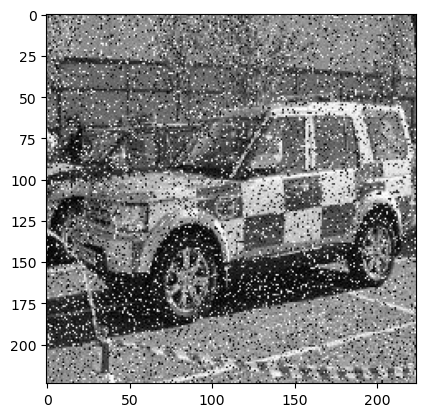

In [38]:
plt.imshow(noisy_test[0].reshape((224,224)), cmap='gray')

As can be seen above, we have managed to reduce the noise, but the definitions of the re-constructed image isn't as good. We probably need a model more complex. 
Let us double the convolutional layers, but also add Batchnormalization and dropout layers. Deeper networks may capture the definitions of the image better.

In [13]:
# define architecture of autoencoder

## this is our input placeholder
input_img = Input(shape=(224,224,1 ))

## "encoded" is the encoded representation of the input
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) #64 filters, 3x3 kernel
encoded= BatchNormalization()(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) #64 filters, 3x3 kernel
encoded= BatchNormalization()(encoded)
encoded= Dropout(0.5)(encoded)
encoded = Conv2D(128, (3, 3),strides=(2, 2), activation='relu', padding='same')(encoded)
encoded= BatchNormalization()(encoded)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
encoded= BatchNormalization()(encoded)
encoded= Dropout(0.5)(encoded)
encoded = Conv2D(256, (3, 3), strides=(2, 2),activation='relu', padding='same')(encoded)
encoded= BatchNormalization()(encoded)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
encoded= BatchNormalization()(encoded)
encoded= Dropout(0.5)(encoded)

## "decoded" is the lossy reconstruction of the input
decoded = Conv2DTranspose(256, (3, 3), strides=(2,2),activation='relu', padding='same')(encoded)
decoded= BatchNormalization()(decoded)
decoded = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded)
decoded= BatchNormalization()(decoded)
decoded = Conv2DTranspose(128, (2, 2), activation='relu',strides=(2,2), padding='same')(decoded) 
decoded= BatchNormalization()(decoded)
decoded = Conv2DTranspose(128, (2, 2), activation='relu', padding='same')(decoded) 
decoded= BatchNormalization()(decoded)
decoded = Conv2DTranspose(64, (2, 2), activation='relu', strides=(2,2), padding='same')(decoded) 
decoded= BatchNormalization()(decoded)
decoded = Conv2DTranspose(64, (2, 2), activation='relu', padding='same')(decoded) 
decoded= BatchNormalization()(decoded)
decoded= Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer= adam, loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 batch_normalization_25 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_26 (Ba  (None, 112, 112, 128)     512       
 tchNormalization)                                         

In [14]:
# train autoencoder
train_history = autoencoder.fit(noisy_train, clean_train, epochs=10, batch_size=64,validation_data=(noisy_train, clean_train))

Epoch 1/10
32/32 [==============================] - 84s 3s/step - loss: 0.0247 - val_loss: 0.0629
Epoch 2/10
32/32 [==============================] - 81s 3s/step - loss: 0.0112 - val_loss: 0.0530
Epoch 3/10
32/32 [==============================] - 80s 3s/step - loss: 0.0101 - val_loss: 0.0574
Epoch 4/10
32/32 [==============================] - 78s 2s/step - loss: 0.0092 - val_loss: 0.0556
Epoch 5/10
32/32 [==============================] - 79s 2s/step - loss: 0.0085 - val_loss: 0.0557
Epoch 6/10
32/32 [==============================] - 80s 3s/step - loss: 0.0082 - val_loss: 0.0521
Epoch 7/10
32/32 [==============================] - 78s 2s/step - loss: 0.0080 - val_loss: 0.0506
Epoch 8/10
32/32 [==============================] - 79s 2s/step - loss: 0.0078 - val_loss: 0.0459
Epoch 9/10
32/32 [==============================] - 78s 2s/step - loss: 0.0074 - val_loss: 0.0448
Epoch 10/10
32/32 [==============================] - 79s 2s/step - loss: 0.0073 - val_loss: 0.0402


The above architecture seems to be significantly overfitting. This may not be an improvement on the initial architecture.

Next we can implement a __U-net architecture__ with skip connections between the corresponding encoder and decoder layers. This helps preserve spatial information during the upsampling process. Upsampling in decoder is used in conjunction with the maxpooling2d in encoder in order to expand the size of the image by inserting new rows and columns in between existing ones, thus increasing its width and height.

In [29]:
# define architecture of autoencoder with skip connections with U-net architecture

## this is our input placeholder
input_img = Input(shape=(224,224,1 ))

#encoder layers
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
pool1= MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

#middle
conv4= Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

#decoder with skip connections
up1= UpSampling2D((2,2))(conv4)
concat1= concatenate([conv3, up1],axis=3) #axis=3 implies concatenation across the axis of channel which thereby preserves spatial information
conv5=Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)

up2= UpSampling2D((2,2))(conv5)
concat2= concatenate([conv2, up2],axis=3) 
conv6=Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)

up3= UpSampling2D((2,2))(conv6)
concat3= concatenate([conv1, up3],axis=3)
conv7=Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)

#output
decoded= decoded= Conv2DTranspose(1, (1, 1), activation='sigmoid', padding='same')(conv7)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 224, 224, 64)         640       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 112, 112, 128)        73856     ['max_pooling2d_9[0][0]'

In [30]:
from keras.optimizers.legacy import Adam

adam= Adam(learning_rate=1e-3)
# compile autoencoder
autoencoder.compile(optimizer= adam, loss='mse')

#we use mean square error because we are comparing the output from the model to the original input, pixel by pixel

In [31]:
# train autoencoder
train_history = autoencoder.fit(noisy_train, clean_train, epochs=5, batch_size=64,validation_data=(noisy_train, clean_train))

Epoch 1/5
32/32 [==============================] - 205s 6s/step - loss: 0.0317 - val_loss: 0.0112
Epoch 2/5
32/32 [==============================] - 194s 6s/step - loss: 0.0097 - val_loss: 0.0078
Epoch 3/5
32/32 [==============================] - 193s 6s/step - loss: 0.0074 - val_loss: 0.0069
Epoch 4/5
32/32 [==============================] - 193s 6s/step - loss: 0.0067 - val_loss: 0.0065
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 0.0070 - val_loss: 0.0067


In [32]:
## read test images
temp = []
for img_name in os.listdir(test_dir):
    image_path = os.path.join(test_dir, img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)
    
## store them in train_x
noisy_test = np.reshape(temp, (-1,224,224,1))
#noisy_test = noisy_test.reshape(-1, 224*224).astype('float32')

# Apply the trained autoencoder model on the test images to denoise them
denoised_test_images = autoencoder.predict(noisy_test)

12/12 [==============================] - 7s 610ms/step


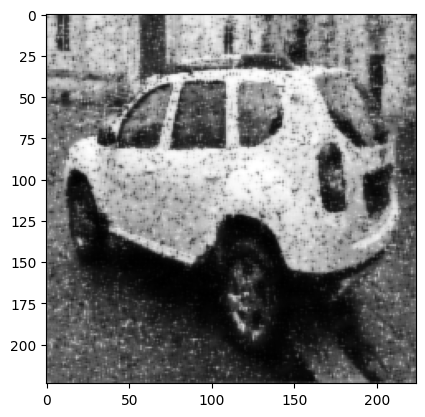

In [35]:
#check output of autoencoder model
plt.imshow(denoised_test_images[1].reshape((224,224)), cmap='gray')

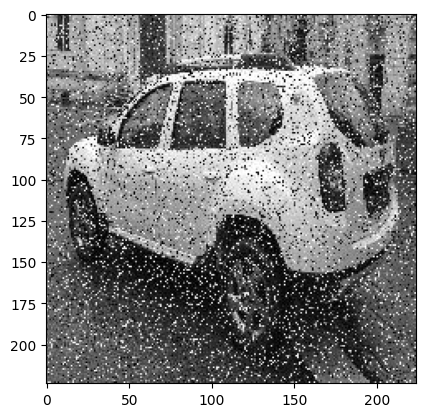

In [36]:
plt.imshow(noisy_test[1].reshape((224,224)), cmap='gray')

As can be have improved upon the loss value and significantly improved upon the base model. This model also captures the definitions of the original image to a good degree. But this can still be improved